In [ ]:

! pip install transformers torch
! python -m spacy download en_core_web_md
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

2023-11-25 12:21:57.956732: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-25 12:21:57.956793: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-25 12:21:57.956829: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 12:21:57.965843: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 12:21:59.133324: W tensorflow/c

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
import nltk
import spacy
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, AutoModelForSequenceClassification
from transformers import pipeline
import base64

model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

qa_model_name = "distilbert-base-uncased-distilled-squad"
qa_tokenizer = AutoTokenizer.from_pretrained(qa_model_name)
qa_model = AutoModelForQuestionAnswering.from_pretrained(qa_model_name)
qa_model = pipeline('question-answering', model=qa_model, tokenizer=qa_tokenizer)

sent_model_name = "distilbert-base-uncased-finetuned-sst-2-english"
sent_tokenizer = AutoTokenizer.from_pretrained(sent_model_name)
sent_model = AutoModelForSequenceClassification.from_pretrained(sent_model_name)
sent_model = pipeline('text-classification', model=sent_model, tokenizer=sent_tokenizer)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
pd.set_option('display.max_colwidth', 500)


In [ ]:
df = pd.read_csv('processed_data.csv')
df.head()

,text,sentiment
0,come ask leave house sunday live eviction show move white room,2
1,gonna lie big brother mess isnt fair even fan,2
2,production team doesnt care bite people mental health sad cant begin imagine whats go head right whos military already battle anxiety,0
3,kayode one responsible show bore hms,2
4,video s fan protest bbnaijas eviction twist lagos,1


In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
nlp = spacy.load('en_core_web_md')


In [ ]:
def get_noun(lines):
	tokenized = nltk.word_tokenize(lines)
	nouns = set([word for (word, pos) in nltk.pos_tag(tokenized) if(pos[:2] == 'NN')])
	return nouns

def get_similar_words(nouns, aspects):
	aspect_classes = {k: list() for k in aspects}
	#aspect_classes = {aspect: [aspect] for aspect in aspects}
	for noun in nouns:
		scores = list()
		for aspect in aspects:
			aspect_token = nlp(aspect)
			noun_token = nlp(noun)
			similarity_score = aspect_token.similarity(noun_token)
			scores.append(similarity_score)
		index = scores.index(max(scores))
		aspect_name = aspects[index]

		if max(scores)>0.50:
			value = aspect_classes[aspect_name]
			value.append(aspect_name)
			value.append(noun)
			aspect_classes[aspect_name] = list(set(value))

		else:
			pass
	return aspect_classes

def get_sentiment(aspect_classes, text):
  sentiment_dict = {k:0 for k in aspect_classes}
  for aspect in aspect_classes:
    alt_names = aspect_classes[aspect]
    for name in alt_names:
      question = f"What do you think about the {name}?"
      # print(question)
      QA_input = {'question': question, 'context': text}
      qa_result = qa_model(QA_input)
      # print(qa_result)
      answer = qa_result['answer']

      #sentiment model
      sent_result = sent_model(answer)
      # print(sent_result)
      sentiment = sent_result[0]['label']

      if sentiment == 'NEGATIVE':
        sentiment, score = 'Negative', -1
      elif sentiment == 'POSITIVE':
        sentiment, score = 'Positive', 1
      else:
        sentiment, score = 'Neutral', 0

      value = sentiment_dict[aspect] + score
      sentiment_dict[aspect] = value
  return sentiment_dict




In [ ]:
# nouns = df.text.apply(get_noun)
df = df[:500]
# df.to_dict()

In [ ]:
def compute(text, aspects):
	#preprocessing
	preprocess_text = text
	#get nouns
	noun_list = get_noun(preprocess_text)
	#get alternative names of aspects
	aspect_classes = get_similar_words(noun_list, aspects)
	#get sentiment
	sentiment_result = get_sentiment(aspect_classes, text)
	#sentiment_result = {'aspect 1': score, 'aspect 2': score, ...}
	return sentiment_result



def aspect_sentiment(aspects):
	tweets_content = df
	aspect_score = {asp : {'positive': 0, 'negative': 0} for asp in aspects}

	#compute scores for each tweet
	if tweets_content.to_dict():
		for text in tweets_content['text']:
			sentiment_result = compute(text, aspects)
			for result in sentiment_result:
				score = sentiment_result[result]
				if score>0:
					aspect_score[result]['positive'] = aspect_score[result]['positive'] + score
				elif score<0:
					aspect_score[result]['negative'] = aspect_score[result]['negative'] - score
				else:
					pass
	else:
		print('No data')


	result_list = [[k, 'positive', v['positive']] for k,v in aspect_score.items()]
	result_list.extend([[k, 'negative', v['negative']] for k,v in aspect_score.items()])

	#plot the bar plot across all aspects
	aspects_df = pd.DataFrame(result_list, columns= ['aspect', 'sentiment', 'score'])
	sns.barplot(x = 'aspect', y = 'score', hue='sentiment', data=aspects_df)

<ipython-input-9-d489543000b4>:14: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  similarity_score = aspect_token.similarity(noun_token)


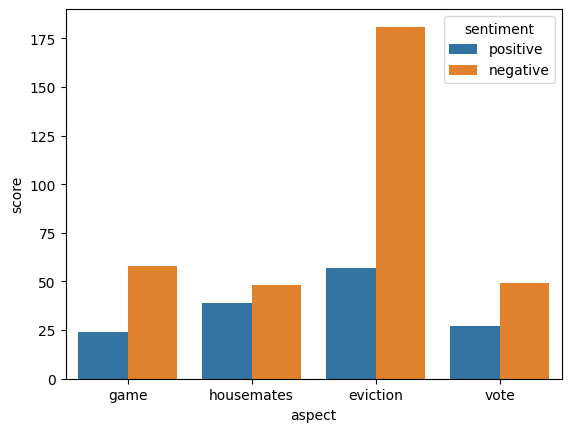

In [ ]:
aspects = ['game', 'housemates', 'eviction', 'vote']
aspect_sentiment(aspects)